In [4]:
using Plots, LaTeXStrings, DifferentialEquations, ForwardDiff, LinearAlgebra, Roots

# Define the Model struct
Base.@kwdef struct Model
    b::Float64 = 0.6
    c::Float64 = 0.25
    rho::Float64 = 0.03
end


Model

In [5]:

# Define functions
function m(x, model::Model)
    model.b * x - x^4 / (1 + x^4)
end


m (generic function with 1 method)

In [6]:

function m_prime(x, model::Model)
    model.b - 4x^3 / (1 + x^4)^2
end

f(x, a, model::Model) = a - m(x, model)

g(x, a, model::Model) = 2 * a * (2model.c * x * sqrt(a) - (model.rho + m_prime(x, model)))


g (generic function with 1 method)

In [7]:

function F!(du, u, model, t)
    du[1] = f(u[1], max(u[2], 0.), model)
    du[2] = g(u[1], max(u[2], 0.), model)
end

field(x, a, model::Model) = F!(Vector{Float64}(undef, 2), [x, a], model, 0.)


field (generic function with 1 method)

In [8]:

function J(x, a, model::Model)
    u = [x, a]
    ForwardDiff.jacobian((du, u) -> F!(du, u, model, 0.), similar(u), u)
end

xspan = (0., 4.); aspan = (0., 0.6);

# Define nullclines
N_x(x, model::Model) = m(x, model)


N_x (generic function with 1 method)

In [9]:

function N_a(x, model::Model)
    num = model.rho + m_prime(x, model)
    den = 2model.c * x
    (ifelse(num > 0., num, NaN) / den)^2
end


N_a (generic function with 1 method)

In [10]:

# Callback for ODE termination
function outofbounds(u, t, integrator)
    !all(0. .< u .< 5.)
end


outofbounds (generic function with 1 method)

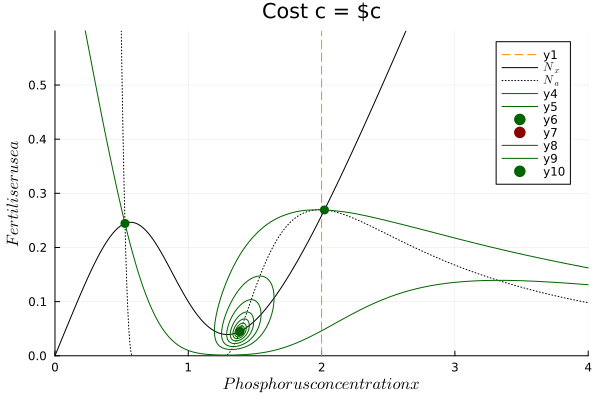

In [11]:

callback = DiscreteCallback(outofbounds, terminate!)
manifoldhorizon = 1000.

# Set parameter values
c = 0.25
rho = 0.03
x₀ = 2.0
model = Model(c = c, rho = rho)

# Define nullcline plots
xspace = range(xspan...; length = 5001)
intervalroots = find_zeros(x -> N_x(x, model) - N_a(x, model), xspan)

nullclinefig = plot(xlims = xspan, ylims = aspan, xlabel = L"Phosphorus concentration x", ylabel = L"Fertiliser use a", title = L"Cost c = $c")
vline!(nullclinefig, [x₀]; c = :darkorange, linestyle = :dash)
plot!(nullclinefig, xspace, x -> N_x(x, model); label = L"N_x", linestyle = :solid, c = :black)
plot!(nullclinefig, xspace, x -> N_a(x, model); label = L"N_a", linestyle = :dot, c = :black)

for x̄ in intervalroots
    ā = N_x(x̄, model)
    jac = J(x̄, ā, model)
    λ, v = eigen(jac)
    issaddle = all.(isreal(λ)) && prod(λ) < 0.
    c = issaddle ? :darkgreen : :darkred
    
    if issaddle
        ū = [x̄, ā]
        vₛ = v[:, λ .< 0] |> vec
        for u₀ in (ū - 1e-4 * vₛ, ū + 1e-4 * vₛ)
            ts = range(0, -manifoldhorizon; step = -0.1)
            prob = ODEProblem(F!, u₀, (0, -manifoldhorizon), model)
            mₛ = solve(prob, callback = callback)
            traj = mₛ(ts).u
            xₜ = getindex.(traj, 1)
            λₜ = getindex.(traj, 2)
            plot!(nullclinefig, xₜ, λₜ; c = :darkgreen)
        end
    end
    scatter!(nullclinefig, [x̄], [ā]; c = c, markersize = 5, markerstrokewidth = 0)
end

# Show the nullcline plot
display(nullclinefig)
